<a href="https://colab.research.google.com/github/cristianmedinamontoya/Stochastic/blob/main/Stochastic_ICU_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Prediction Model ICU hospital


In [1]:
#This part is the libraries that i import that we use for running the line of codes over this notebook
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

In [2]:
#Here we can read the csv file from my github repository as raw csv
url = "https://raw.githubusercontent.com/cristianmedinamontoya/Stochastic/main/DataForClass.csv"
data = pd.read_csv(url, sep=";")


In [3]:
#Here we can check the data frame head
data.head()

,id,codes,age,gender,dates,bad,last,SAPS,Glasgow,TISS,PA,FC,Temp,dayIn
0,8309,20017421,60,1,10/10/2019,0,in,NaN,6.0,NaN,73.0,130.0,37.30,1
1,8309,20017421,60,1,11/10/2019,0,in,85.0,5.0,37.0,71.0,100.0,37.69,2
2,8309,20017421,60,1,12/10/2019,0,in,66.0,10.0,35.0,94.0,95.0,37.69,3
3,8309,20017421,60,1,13/10/2019,1,last,57.0,14.0,29.0,101.0,93.0,37.88,4
4,6112,40026409,60,1,28/04/2018,0,in,NaN,11.0,29.0,36.0,124.0,36.32,1


In [4]:
# Handling missing values using KNNImputer
imputer = KNNImputer(n_neighbors=7)
data[['SAPS', 'Glasgow', 'TISS', 'PA', 'FC', 'Temp']] = imputer.fit_transform(data[['SAPS', 'Glasgow', 'TISS', 'PA', 'FC', 'Temp']])

In [5]:
# Selecting relevant features (excluding 'id', 'codes', and 'last which are likely non-predictive)
features = ['age', 'gender', 'SAPS', 'Glasgow', 'TISS', 'PA', 'FC', 'Temp', 'dayIn']
X = data[features] #This uses all other values as features/labels to be used in the model KNN
y = data['bad'] # According to the predictive model - The column "bad" is designed to be the target

In [6]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((4982, 9), (1246, 9))

In [7]:
#I run SMOTE for imbalanced samples
smote = SMOTE(random_state=12)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
X_test_res, y_test_res = smote.fit_resample(X_test, y_test)

In [8]:
#In this line of code I check the SMOTE result for imbalanced result
unique, count = np.unique(y_train_res, return_counts=True)
y_train_smote_value_count = { k:v for (k,v) in zip(unique, count)}
y_train_smote_value_count

{0: 4263, 1: 4263}

In [9]:
#Now checking that i got binary classification balanced after SMOTE I proceed to the run the model
param_dict = {
    'learning_rate': [0.1, 0.2],
    'n_estimators': [20, 50, 75],
    'max_depth': [1, 3, 5, None],
    'n_iter_no_change': [None, 1, 5, 10]
}

grid_clf = GridSearchCV(
    estimator = GradientBoostingClassifier(),
    param_grid = param_dict,
    scoring = 'f1_weighted',
    refit = True,
    cv = 3,
    verbose = 10,
    n_jobs = -1
)

grid_clf.fit(X_train_res, y_train_res)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2],
                         'max_depth': [1, 3, 5, None],
                         'n_estimators': [20, 50, 75],
                         'n_iter_no_change': [None, 1, 5, 10]},
             scoring='f1_weighted', verbose=10)

In [10]:
#Here we check the balanced values from 0 & 1
y_train_res.eq(0).sum(), y_train_res.eq(1).sum()

(4263, 4263)

In [11]:
#Predict on the test set
y_pred = grid_clf.best_estimator_.predict(X_test_res)

In [12]:
#Results from the model
print('Best hyper-parameters:', grid_clf.best_params_)
print('Best score:', grid_clf.best_score_)
print(classification_report(y_test_res, y_pred))

Best hyper-parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 75, 'n_iter_no_change': 5}
Best score: 0.8822195476170188
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1078
           1       0.90      0.86      0.88      1078

    accuracy                           0.88      2156
   macro avg       0.88      0.88      0.88      2156
weighted avg       0.88      0.88      0.88      2156



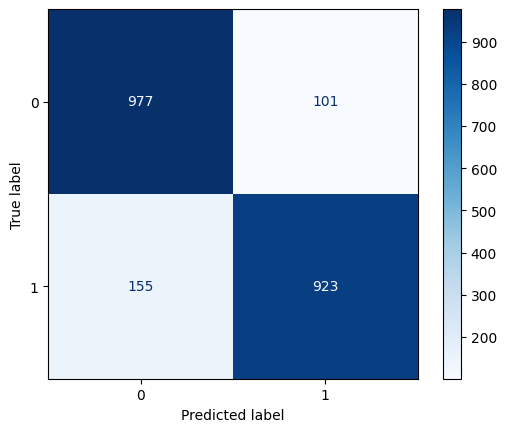

In [13]:
#Confusion Matrix
cm = confusion_matrix(y_test_res, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1]).plot(values_format='d', cmap="Blues")

In [14]:
X_test1 = X_test

# Using the predictions in the main dataset & Calculation for Anylogic input

In [15]:
y_pred_df = pd.DataFrame(y_pred)
# y_pred_df

In [16]:
data_1 = pd.DataFrame(data)
# data_1

In [17]:
y_pred_originalset = grid_clf.best_estimator_.predict(X)

In [18]:
y_pred_originalset_df = pd.DataFrame(y_pred_originalset)

In [19]:
y_pred_originalset_df = y_pred_originalset_df.rename(columns={0: 'bad_pred'})

In [20]:
data_1['bad_pred'] = y_pred_originalset_df['bad_pred']

In [21]:
conditions = [
    (data_1['bad_pred'] == 0) & (data_1['last'] == 'in'),
    (data_1['bad_pred'] == 1) & (data_1['last'] == 'in'),
    (data_1['bad_pred'] == 0) & (data_1['last'] == 'last'),
    (data_1['bad_pred'] == 1) & (data_1['last'] == 'last')
]

In [22]:
classifications = ['S&S', 'S&L', 'L&S', 'L&L']

In [23]:
data_1['classification'] = pd.Series(np.select(conditions, classifications, default='Unknown'))

In [24]:
data_1['dates'] = pd.to_datetime(data_1['dates'], format='%d/%m/%Y')

In [26]:
data_1[['bad_pred', 'last', 'classification']].head(10)

,bad_pred,last,classification
0,0,in,S&S
1,0,in,S&S
2,0,in,S&S
3,1,last,L&L
4,0,in,S&S
5,0,in,S&S
6,0,in,S&S
7,1,in,S&L
8,0,in,S&S
9,0,in,S&S


In [27]:
daily_counts = data_1.groupby([data_1['dates'].dt.normalize(), 'classification']).size().unstack(fill_value=0)


In [28]:
daily_in = daily_counts[['S&S', 'S&L']].sum(axis=1)
daily_out = daily_counts[['L&S', 'L&L']].sum(axis=1)

In [29]:
average_in_rate = daily_in.mean()
average_out_rate = daily_out.mean()

average_in_rate.round(2), average_out_rate.round(2)

(7.37, 1.16)

# Using Multi-layer ANN to optimize the confusion matrix & Classification Report

In [30]:
# import libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [31]:
X_test_res_array = pd.DataFrame(X_test_res).values

In [32]:
# feature scaling
scaler = StandardScaler()
scaled_feature = scaler.fit_transform(X_test_res_array)

In [33]:
# Split the dataset into train, validation, and test sets
train_val_feature, test_feature, train_val_label, test_label = train_test_split(
    scaled_feature, y_test_res, test_size = 0.2, random_state = 0
)
train_feature, val_feature, train_label, val_label = train_test_split(
    train_val_feature, train_val_label, test_size = 0.25, random_state = 0
)

In [34]:
val_label = pd.Series(val_label).values

In [35]:
test_label = pd.Series(test_label).values

In [36]:
#Train, validation, and test

train_ds = TensorDataset(
    torch.tensor(train_feature, dtype = torch.float32),
    torch.tensor(train_label, dtype = torch.float32)
)
val_ds = TensorDataset(
    torch.tensor(val_feature, dtype = torch.float32),
    torch.tensor(val_label, dtype = torch.float32)
)
test_ds = TensorDataset(
    torch.tensor(test_feature, dtype = torch.float32),
    torch.tensor(test_label, dtype = torch.float32)
)

In [37]:
# create the train and test data loaders
batch_size = 64 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

In [38]:
# define a custom neural network class
class BinaryClassificationNet(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
            nn.Sigmoid()
        )
    def forward(self, X):
        return self.net(X)

In [39]:
# model = LogisticRegressionNet(n_features = X_test_res_array.shape[1])
model = BinaryClassificationNet(n_features = X_test_res_array.shape[1])

In [40]:
# define the training function
def train(train_dl, val_dl, model, loss_fn, optimizer, epochs, early_stopping_patience, lr_scheduler):
    # initialization
    min_val_loss = np.inf # initialize the val loss as an infinite positive value
    patience_counter = 0 # set the initial patience counter to zero
    train_batch_loss_history = [] # for recording the average train loss of a batch
    train_epoch_loss_history = [] # for recording the average train loss of an epoch
    val_batch_loss_history = [] # for recording the average val loss of an batch
    val_epoch_loss_history = [] # for recording the average val loss of an epoch

    # start training
    for epoch in range(epochs): # iterate pre-defined number of epoches
        # train set
        train_epoch_loss = 0.0 # initial train epoch loss is set to zero
        model.train() # set the model in training mode
        for (X, y) in train_dl: # get a batch of training samples
            prob = model(X).squeeze() # make predictions, squeeze() reduce `prob` to 1D tensor
            train_batch_loss = loss_fn(prob, y) # compute the current train batch loss
            train_batch_loss.backward() # compute gradients by backpropagation
            optimizer.step() # update learning parameters according to gradients
            optimizer.zero_grad() # reset the gradients to zero
            train_batch_loss_history.append(train_batch_loss.item()) # record current train batch loss
            train_epoch_loss += train_batch_loss.item() # accumulate train batch losses for compute train epoch loss
        train_epoch_loss /= len(train_dl) # compute current train epoch loss
        train_epoch_loss_history.append(train_epoch_loss) # record current train epoch loss
        # validation set
        val_epoch_loss = 0.0 # initial val epoch loss is set to zero
        model.eval() # set the model in evaluation mode
        with torch.no_grad():
            for (X, y) in val_dl: # get a batch of validation samples
                prob = model(X).squeeze() # make predictions, squeeze() reduce `prob` to 1D tensor
                val_batch_loss = loss_fn(prob, y) # compute the current val batch loss
                val_batch_loss_history.append(val_batch_loss.item()) # record current val batch loss
                val_epoch_loss += val_batch_loss.item() # accumulate val batch losses for compute val epoch loss
            val_epoch_loss /= len(val_dl) # compute current val epoch loss
            val_epoch_loss_history.append(val_epoch_loss) # record current val epoch loss
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}") # print log
        # learning rate decay
        old_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if old_lr != new_lr:
            print(f'Learning rate reduced after epoch {epoch+1}')
        # early stopping
        if val_epoch_loss < min_val_loss:
            min_val_loss = val_epoch_loss # update the new min val loss
            patience_counter = 0 # reset patience counter to zero
        else:
            patience_counter += 1 # increase patience counter by 1
        if patience_counter >= early_stopping_patience:
            print('Early stopping!')
            break
    return train_batch_loss_history, val_batch_loss_history, train_epoch_loss_history, val_epoch_loss_history

In [41]:
# define the training hyper-parameters
loss_fn = nn.BCELoss() # binary cross entropy loss
learning_rate = 1e-1
weight_decay = 1e-5 # lambda for L2 regularization
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 1000
early_stopping_patience = 20
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1, # each step multiply the learning rate with 0.1
    patience = 5
)

In [42]:
train_batch_loss_history, val_batch_loss_history, train_epoch_loss_history, val_epoch_loss_history = train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler
)

Epoch 1: train loss = 0.691288, val loss = 0.689639
Epoch 2: train loss = 0.689492, val loss = 0.686750
Epoch 3: train loss = 0.687095, val loss = 0.683844
Epoch 4: train loss = 0.683690, val loss = 0.679679
Epoch 5: train loss = 0.679560, val loss = 0.672899
Epoch 6: train loss = 0.670636, val loss = 0.660015
Epoch 7: train loss = 0.654054, val loss = 0.638402
Epoch 8: train loss = 0.634288, val loss = 0.613252
Epoch 9: train loss = 0.605116, val loss = 0.584237
Epoch 10: train loss = 0.575319, val loss = 0.563566
Epoch 11: train loss = 0.555518, val loss = 0.549189
Epoch 12: train loss = 0.537617, val loss = 0.536787
Epoch 13: train loss = 0.525915, val loss = 0.530198
Epoch 14: train loss = 0.522867, val loss = 0.526667
Epoch 15: train loss = 0.510638, val loss = 0.522966
Epoch 16: train loss = 0.505243, val loss = 0.518727
Epoch 17: train loss = 0.504848, val loss = 0.517005
Epoch 18: train loss = 0.492788, val loss = 0.515337
Epoch 19: train loss = 0.496745, val loss = 0.509393
Ep

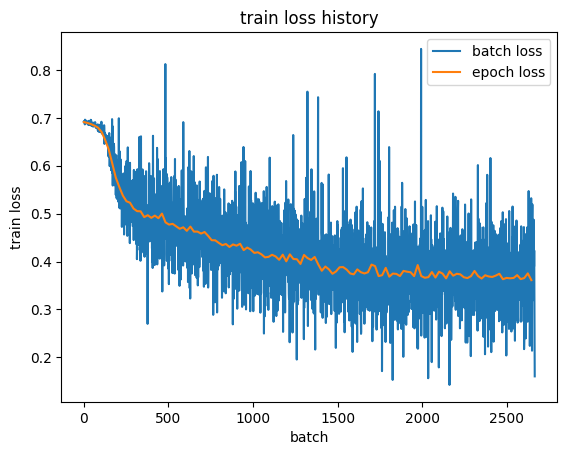

In [43]:
# plot the train loss history
plt.figure()
batch = np.arange(len(train_batch_loss_history))
epoch = np.arange(len(train_epoch_loss_history))
batches_per_epoch = (int(len(train_feature) / batch_size + 1))
plt.plot(batch, train_batch_loss_history, '-', label = 'batch loss')
plt.plot(epoch * batches_per_epoch, train_epoch_loss_history, '-', label = 'epoch loss')
plt.title('train loss history')
plt.xlabel('batch')
plt.ylabel('train loss')
plt.legend()
plt.show()

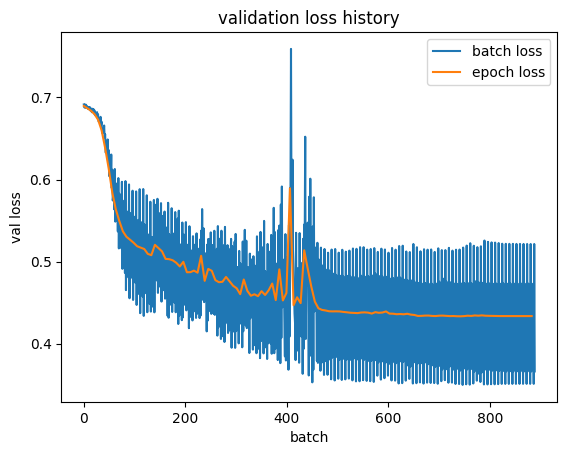

In [44]:
# plot the val loss history
plt.figure()
batch = np.arange(len(val_batch_loss_history))
epoch = np.arange(len(val_epoch_loss_history))
batches_per_epoch = (int(len(val_feature) / batch_size + 1))
plt.plot(batch, val_batch_loss_history, '-', label = 'batch loss')
plt.plot(epoch * batches_per_epoch, val_epoch_loss_history, '-', label = 'epoch loss')
plt.title('validation loss history')
plt.xlabel('batch')
plt.ylabel('val loss')
plt.legend()
plt.show()

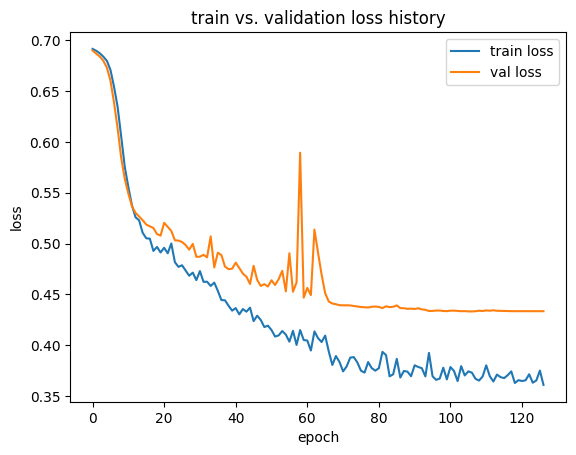

In [45]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(train_epoch_loss_history)), train_epoch_loss_history, '-', label = 'train loss')
plt.plot(np.arange(len(val_epoch_loss_history)), val_epoch_loss_history, '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [46]:
# save model
file_name = 'Binary_classification.pth'
torch.save(model.state_dict(), file_name)
print('Saved PyTorch Model State to '+ file_name)

Saved PyTorch Model State to Binary_classification.pth


In [47]:
# load model
model = BinaryClassificationNet(n_features = X_test_res_array.shape[1])
model.load_state_dict(torch.load(file_name))

<All keys matched successfully>

In [48]:
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    batch_prob_list = [] # for recording batch predictions
    model.eval() # set the model in evaluation mode
    with torch.no_grad(): # disable automatic gradient computing
        loss = 0.0 # set initial test loss to zero
        for (X, y) in dataloader: # get a batch from test samples
            batch_prob = model(X).squeeze() # make predictions, squeeze() reduce `batch_prob` to 1D tensor
            batch_loss = loss_fn(batch_prob, y) # compute current batch loss
            loss += batch_loss.item() # accumulate batch losses for compute test loss
            batch_prob_list.append(batch_prob) # record predictions on current batch
        loss /= len(dataloader) # compute test loss
        prob = np.concatenate(batch_prob_list) # reform the predictions as a numpy 1D array
        print(f"test loss = {loss}") # print log
    return prob, loss

In [49]:
# make prediction on test set and evaluate the performance
test_prob, test_loss = test(test_dl, model, loss_fn)

test loss = 0.49082379255975994


In [50]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_label, test_prob)
roc_auc = auc(fpr, tpr)

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Convert probability to predicted class using the optimal threshold
test_pred = (test_prob > optimal_threshold)

In [51]:
print("Optimal Threshold:", optimal_threshold)

Optimal Threshold: 0.3506654


In [52]:
test_pred = (test_prob > optimal_threshold) # convert the probability to predicted class by a threshold
print(classification_report(test_label, test_pred))

              precision    recall  f1-score   support

           0       0.89      0.69      0.78       218
           1       0.74      0.92      0.82       214

    accuracy                           0.80       432
   macro avg       0.82      0.80      0.80       432
weighted avg       0.82      0.80      0.80       432



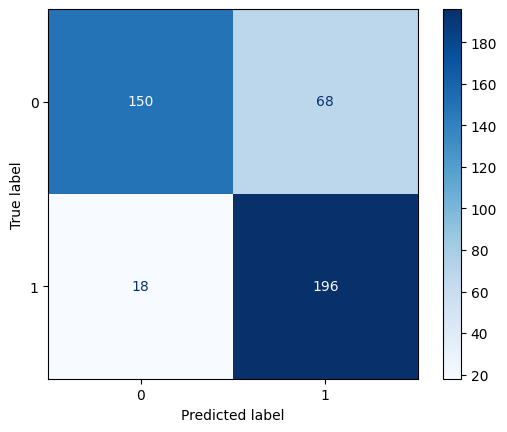

In [53]:
#Confusion Matrix
cm = confusion_matrix(test_label, test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1]).plot(values_format='d', cmap="Blues")